# Trabalho 2 Unidade 2 — A* + MST


**Referências obrigatórias:**
- Notebook-base I: [`week07/Astar.ipnyb`](https://github.com/ivanovitchm/datastructure/blob/main/lessons/week07/Astar.ipynb)  
- Notebook-base II: [`week08/kruskal_natal.ipynb`](https://github.com/ivanovitchm/datastructure/blob/main/lessons/week08/kruskal_natal.ipynb)  

## Objetivo
Dado um conjunto de pontos de interesse (POIs) em uma cidade, estimar quantos quilômetros são suficientes para interligá-los por vias reais.  
Você deverá:
1) Modelar o grafo viário da(s) cidade(s) com OSMnx (ou equivalente);  
2) Calcular rotas mais curtas com A\* entre POIs;  
3) Construir e calcular a Árvore Geradora Mínima (MST) sobre o grafo completo entre POIs (arestas ponderadas pelo custo A\* nas vias) para obter o comprimento total mínimo necessário para conectar todos os POIs;  
4) Comparar o resultado com pelo menos 8 cidades.


<img src="https://drive.google.com/uc?export=view&id=1d84mGH_6c-IZus9QMS8MjYvneVgz68Wf" width="300">



## O que fazer (passo a passo)



### 1) Escolha dos POIs
- Escolha livre dos POIs (ex.: campus, museus, praças, arenas, hubs de transporte, escolas, ponto de onibus, locais turísticos, etc).
- Escolha um POI diferente do Notebook-base II.

### 2) Grafo viário da cidade
- Baixe o grafo viário com OSMnx (`graph_from_place` ou `graph_from_polygon`).  
- Projete o grafo para métrica (UTM) antes de medir distâncias (mesma estratégia usada no Notebook-base II).
- Para cada POI, pegue o nó mais próximo no grafo.

### 3) Rotas mais curtas com A\*
- Para cada par de POIs da cidade, compute o caminho mínimo usando A\* (heurística: distância em linha reta/“great-circle” ou Euclidiana no plano projetado).  
- Registre o custo (distância) de cada par e guarde a rota (lista de nós/arestas) para visualização posterior.  
  - Pode usar `networkx.astar_path`/`astar_path_length` ou implementar A\*.

### 4) MST sobre o grafo completo de POIs
- Com os pesos = distâncias A\* entre cada par de POIs, forme um grafo completo (POIs como vértices).  
- Calcule a MST (ex.: Kruskal) e some os pesos das arestas da MST → “km suficientes para ligar os POIs”.  
- Mapeie de volta cada aresta da MST para a rota na malha viária (união das rotas A\* correspondentes) e compute também o comprimento total real dessa rede resultante.

### 5) Comparação entre ≥ 8 cidades
- Repita os passos 1–4 em pelo menos 8 cidades (pode incluir Natal como uma delas).  
- Compare:  
  - Comprimento da MST (km);   
  - Média e Desvio Padrão por POI (km/POI) ou por par conectado da MST (km/aresta-MST);  

### 6) Visualização e análise
- Plote, para cada cidade, o subgrafo final (união das rotas A\* que compõem a MST entre POIs).  
- Produza tabela comparativa consolidando as métricas.  
- Escreva análise crítica (≈ 10–15 linhas): por que certas cidades exigem mais/menos km? Efeito da escolha de POIs? Limitações do método? O texto deverá estar no arquivo Markdown (README.md)





## Entregáveis


No repositório do grupo, inclua o mesmo formato apresentado no desafio anterior (`week06/challenge.ipynb`).



Critérios de avaliação — **3,0 pontos (Unidade 2)**

1. **Modelagem & dados**
2. **A\* funcional e bem justificado**
3. **MST & reconstrução na malha**
4. **Comparação entre ≥ 8 cidades**
5. **Qualidade do projeto**
6. **Vídeo (até 10 min)**
7. O trabalho poderá ser realizado de forma **individual** ou em **dupla**
8. Prazo: 11 de novembro de 2025 (terça-feira 23h59)

In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 1.7 MB/s eta 0:00:00


In [2]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

In [4]:
places = [
          "Natal, Rio Grande do Norte, Brazil",
          "Parnamirim, Rio Grande do Norte, Brazil",
          "São Gonçalo do Amarante, Rio Grande do Norte, Brazil",
          "Extremoz, Rio Grande do Norte, Brazil",
          "Macaíba, Rio Grande do Norte, Brazil",
          "Ceará-Mirim, Rio Grande do Norte, Brazil",
          "São José de Mipibu, Rio Grande do Norte, Brazil",
          "Nísia Floresta, Rio Grande do Norte, Brazil"
          ]

In [5]:
# Juntar todos as metricas
dados = {}

## Natal

In [6]:
G = ox.graph_from_place(places[0], network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

Plotting the street network...


/tmp/ipython-input-4042706178.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


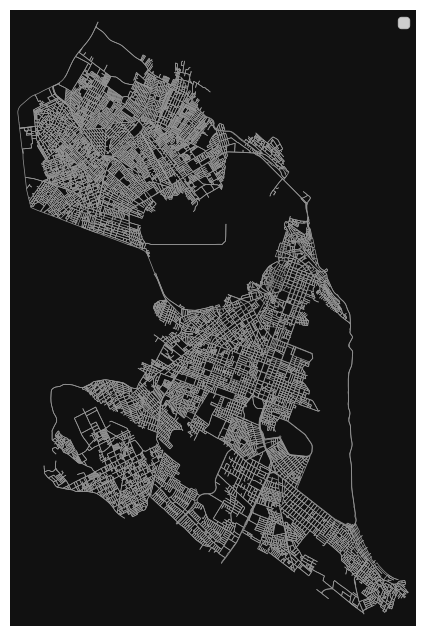

In [7]:
# Plot the street network
print("Plotting the street network...")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, show=False, close=False)

# Add a legend to distinguish source and destination
ax.legend(loc='upper right')

# Display the plot
plt.show()

In [8]:
# ============================================
# 2. Obter POIs de interesse
# ============================================
library_points = []
try:
  tags = {'amenity': 'library'}
  pois = ox.features.features_from_place(places[0], tags=tags)
  for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        library_points.append((row.geometry.y, row.geometry.x))
    else:
        library_points.append((row.geometry.centroid.y, row.geometry.centroid.x))
except:
  print("Nenhum biblioteca encontrada.")


# Extrair pontos representativos (centroides se for polígono)
university_points = []
try:
  tags = {'amenity': 'university'}
  pois = ox.features.features_from_place(places[0], tags=tags)
except:
  print("Nenhum universidade encontrada. Tentando escolas...")
  tags = {'amenity': 'school'}
  pois = ox.features.features_from_place(places[0], tags=tags)

for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        university_points.append((row.geometry.y, row.geometry.x))
    else:
        university_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not university_points:
    print("Nenhuma escola ou universidade encontrada.")

In [9]:
len(library_points)

15

In [10]:
len(university_points)

14

In [11]:
# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [hp[0] for hp in university_points]
longitudes = [hp[1] for hp in university_points]
university_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
university_nodes = list(set(university_nodes))

latitudes = [hp[0] for hp in library_points]
longitudes = [hp[1] for hp in library_points]
library_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
library_nodes = list(set(library_nodes))


In [12]:
# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for university in university_nodes:
    for library in library_nodes:
        route = nx.shortest_path(G_undirected, university, library, weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(university, library, weight=route_length)

In [13]:
# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_weight = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs):", total_mst_weight, "metros")

mean_mst_edge_weight = 0
std_dev_mst_edge_weight = 0
mst_edge_weights = [d['weight'] for (u, v, d) in mst_edges]
if mst_edge_weights:
    mean_mst_edge_weight = sum(mst_edge_weights) / len(mst_edge_weights)

    sum_sq_diff = sum([(w - mean_mst_edge_weight) ** 2 for w in mst_edge_weights])
    std_dev_mst_edge_weight = (sum_sq_diff / len(mst_edge_weights)) ** 0.5

    print(f"Média do peso das arestas do MST: {mean_mst_edge_weight:.2f} metros/aresta")
    print(f"Desvio padrão do peso das arestas do MST: {std_dev_mst_edge_weight:.2f} metros/aresta")

mst_routes = []
for (u, v, d) in mst_edges:
    route = nx.shortest_path(G_undirected, u, v, weight='length')
    mst_routes.append(route)

total_real_length = 0
edges_between_nodes = 0
for route in mst_routes:
    for i in range(len(route) - 1):
        edges_between_nodes = G_undirected.get_edge_data(route[i], route[i+1])
        for key in edges_between_nodes:
            total_real_length += edges_between_nodes[key]['length']


print("Comprimento total real da rede formada pelas rotas do MST:", total_real_length, "metros")

dados[places[0]] = [total_mst_weight, mean_mst_edge_weight, std_dev_mst_edge_weight, total_real_length]

Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs): 62323.72094774457 metros
Média do peso das arestas do MST: 2492.95 metros/aresta
Desvio padrão do peso das arestas do MST: 3115.23 metros/aresta
Comprimento total real da rede formada pelas rotas do MST: 74915.08082372675 metros


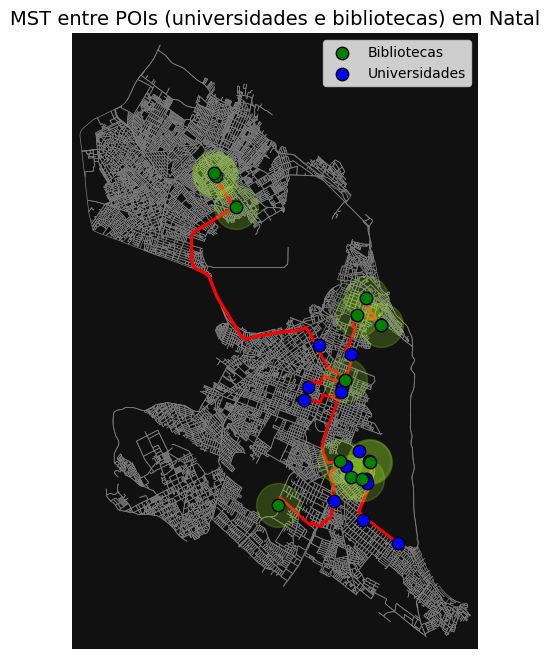

In [14]:
# Plotar o grafo base
fig, ax = ox.plot_graph(
    G_undirected, node_size=0, edge_color="gray", edge_linewidth=0.5, show=False, close=False
)

# Plotar também os POIs (bibliotecas) em verde
poi_x = [G_undirected.nodes[n]['x'] for n in library_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in library_nodes]
ax.scatter(poi_x, poi_y, c='greenyellow', s=1000, zorder=5, alpha=0.2)
ax.scatter(poi_x, poi_y, c='green', s=80, zorder=6, edgecolor='black', label='Bibliotecas')

# Destacar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotar também os POIs (universidades) em azul
poi_x = [G_undirected.nodes[n]['x'] for n in university_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in university_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black', label='Universidades')

plt.title("MST entre POIs (universidades e bibliotecas) em Natal", fontsize=14)
ax.legend()
plt.savefig("natal_mst.png", dpi=500, bbox_inches='tight')
plt.show()

## Parnamirim

In [15]:
G = ox.graph_from_place(places[1], network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

Plotting the street network...


/tmp/ipython-input-4042706178.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


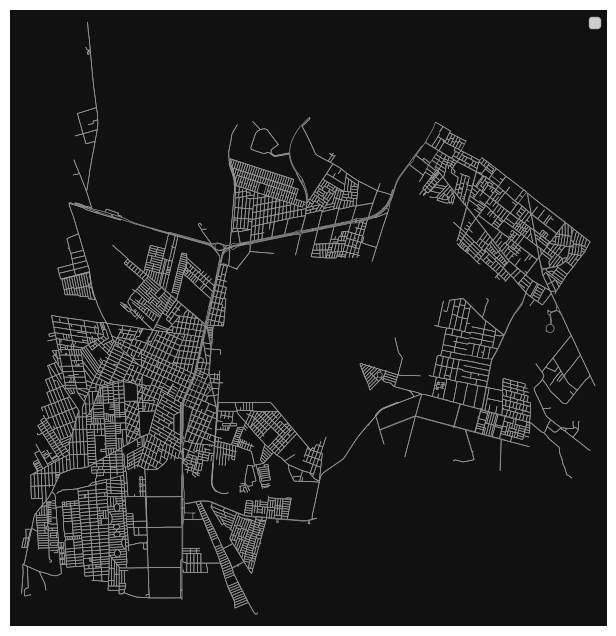

In [16]:
# Plot the street network
print("Plotting the street network...")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, show=False, close=False)

# Add a legend to distinguish source and destination
ax.legend(loc='upper right')

# Display the plot
plt.show()

In [17]:
# ============================================
# 2. Obter POIs de interesse
# ============================================
library_points = []
try:
  tags = {'amenity': 'library'}
  pois = ox.features.features_from_place(places[1], tags=tags)
  for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        library_points.append((row.geometry.y, row.geometry.x))
    else:
        library_points.append((row.geometry.centroid.y, row.geometry.centroid.x))
except:
  print("Nenhum biblioteca encontrada.")


# Extrair pontos representativos (centroides se for polígono)
university_points = []
try:
  tags = {'amenity': 'university'}
  pois = ox.features.features_from_place(places[1], tags=tags)
except:
  print("Nenhum universidade encontrada. Tentando escolas...")
  tags = {'amenity': 'school'}
  pois = ox.features.features_from_place(places[1], tags=tags)

for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        university_points.append((row.geometry.y, row.geometry.x))
    else:
        university_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not university_points:
    print("Nenhuma escola ou universidade encontrada.")

Nenhum universidade encontrada. Tentando escolas...


In [18]:
len(library_points)

1

In [19]:
len(university_points)

51

In [20]:
# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [hp[0] for hp in university_points]
longitudes = [hp[1] for hp in university_points]
university_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
university_nodes = list(set(university_nodes))

latitudes = [hp[0] for hp in library_points]
longitudes = [hp[1] for hp in library_points]
library_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
library_nodes = list(set(library_nodes))


In [21]:
# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for university in university_nodes:
    for library in library_nodes:
        route = nx.shortest_path(G_undirected, university, library, weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(university, library, weight=route_length)

In [22]:
# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_weight = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs):", total_mst_weight, "metros")

mean_mst_edge_weight = 0
std_dev_mst_edge_weight = 0
mst_edge_weights = [d['weight'] for (u, v, d) in mst_edges]
if mst_edge_weights:
    mean_mst_edge_weight = sum(mst_edge_weights) / len(mst_edge_weights)

    sum_sq_diff = sum([(w - mean_mst_edge_weight) ** 2 for w in mst_edge_weights])
    std_dev_mst_edge_weight = (sum_sq_diff / len(mst_edge_weights)) ** 0.5

    print(f"Média do peso das arestas do MST: {mean_mst_edge_weight:.2f} metros/aresta")
    print(f"Desvio padrão do peso das arestas do MST: {std_dev_mst_edge_weight:.2f} metros/aresta")

mst_routes = []
for (u, v, d) in mst_edges:
    route = nx.shortest_path(G_undirected, u, v, weight='length')
    mst_routes.append(route)

total_real_length = 0
edges_between_nodes = 0
for route in mst_routes:
    for i in range(len(route) - 1):
        edges_between_nodes = G_undirected.get_edge_data(route[i], route[i+1])
        for key in edges_between_nodes:
            total_real_length += edges_between_nodes[key]['length']


print("Comprimento total real da rede formada pelas rotas do MST:", total_real_length, "metros")

dados[places[1]] = [total_mst_weight, mean_mst_edge_weight, std_dev_mst_edge_weight, total_real_length]

Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs): 242503.96179262578 metros
Média do peso das arestas do MST: 5639.63 metros/aresta
Desvio padrão do peso das arestas do MST: 2453.70 metros/aresta
Comprimento total real da rede formada pelas rotas do MST: 327175.2939825441 metros


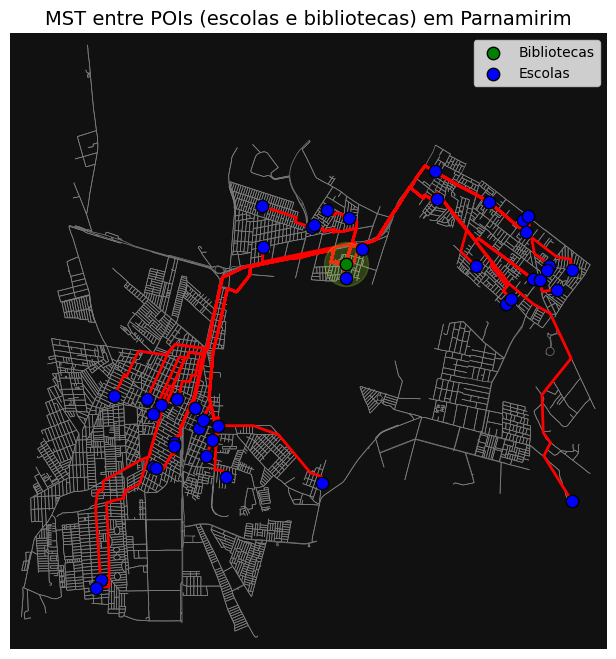

In [23]:
# Plotar o grafo base
fig, ax = ox.plot_graph(
    G_undirected, node_size=0, edge_color="gray", edge_linewidth=0.5, show=False, close=False
)

# Plotar também os POIs (bibliotecas) em verde
poi_x = [G_undirected.nodes[n]['x'] for n in library_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in library_nodes]
ax.scatter(poi_x, poi_y, c='greenyellow', s=1000, zorder=5, alpha=0.2)
ax.scatter(poi_x, poi_y, c='green', s=80, zorder=6, edgecolor='black', label='Bibliotecas')

# Destacar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotar também os POIs (universidades) em azul
poi_x = [G_undirected.nodes[n]['x'] for n in university_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in university_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black', label='Escolas')

plt.title("MST entre POIs (escolas e bibliotecas) em Parnamirim", fontsize=14)
ax.legend()
plt.savefig("parnamirim_mst.png", dpi=500, bbox_inches='tight')
plt.show()

## São Gonçalo do Amarante

In [24]:
G = ox.graph_from_place(places[2], network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

Plotting the street network...


/tmp/ipython-input-4042706178.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


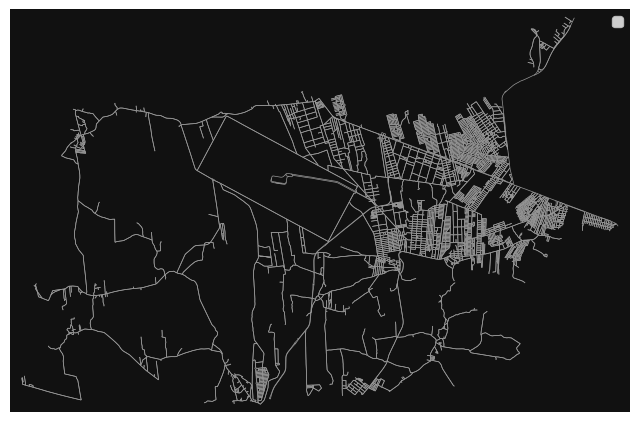

In [25]:
# Plot the street network
print("Plotting the street network...")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, show=False, close=False)

# Add a legend to distinguish source and destination
ax.legend(loc='upper right')

# Display the plot
plt.show()

In [26]:
# ============================================
# 2. Obter POIs de interesse
# ============================================
library_points = []
try:
  tags = {'amenity': 'library'}
  pois = ox.features.features_from_place(places[2], tags=tags)
  for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        library_points.append((row.geometry.y, row.geometry.x))
    else:
        library_points.append((row.geometry.centroid.y, row.geometry.centroid.x))
except:
  print("Nenhum biblioteca encontrada.")


# Extrair pontos representativos (centroides se for polígono)
university_points = []
try:
  tags = {'amenity': 'university'}
  pois = ox.features.features_from_place(places[2], tags=tags)
except:
  print("Nenhum universidade encontrada. Tentando escolas...")
  tags = {'amenity': 'school'}
  pois = ox.features.features_from_place(places[2], tags=tags)

for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        university_points.append((row.geometry.y, row.geometry.x))
    else:
        university_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not university_points:
    print("Nenhuma escola ou universidade encontrada.")

In [27]:
len(library_points)

2

In [28]:
len(university_points)

1

In [29]:
# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [hp[0] for hp in university_points]
longitudes = [hp[1] for hp in university_points]
university_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
university_nodes = list(set(university_nodes))

latitudes = [hp[0] for hp in library_points]
longitudes = [hp[1] for hp in library_points]
library_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
library_nodes = list(set(library_nodes))


In [30]:
# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for university in university_nodes:
    for library in library_nodes:
        route = nx.shortest_path(G_undirected, university, library, weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(university, library, weight=route_length)

In [31]:
# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_weight = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs):", total_mst_weight, "metros")

mean_mst_edge_weight = 0
std_dev_mst_edge_weight = 0
mst_edge_weights = [d['weight'] for (u, v, d) in mst_edges]
if mst_edge_weights:
    mean_mst_edge_weight = sum(mst_edge_weights) / len(mst_edge_weights)

    sum_sq_diff = sum([(w - mean_mst_edge_weight) ** 2 for w in mst_edge_weights])
    std_dev_mst_edge_weight = (sum_sq_diff / len(mst_edge_weights)) ** 0.5

    print(f"Média do peso das arestas do MST: {mean_mst_edge_weight:.2f} metros/aresta")
    print(f"Desvio padrão do peso das arestas do MST: {std_dev_mst_edge_weight:.2f} metros/aresta")

mst_routes = []
for (u, v, d) in mst_edges:
    route = nx.shortest_path(G_undirected, u, v, weight='length')
    mst_routes.append(route)

total_real_length = 0
edges_between_nodes = 0
for route in mst_routes:
    for i in range(len(route) - 1):
        edges_between_nodes = G_undirected.get_edge_data(route[i], route[i+1])
        for key in edges_between_nodes:
            total_real_length += edges_between_nodes[key]['length']


print("Comprimento total real da rede formada pelas rotas do MST:", total_real_length, "metros")

dados[places[2]] = [total_mst_weight, mean_mst_edge_weight, std_dev_mst_edge_weight, total_real_length]

Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs): 9068.808359393488 metros
Média do peso das arestas do MST: 4534.40 metros/aresta
Desvio padrão do peso das arestas do MST: 4020.35 metros/aresta
Comprimento total real da rede formada pelas rotas do MST: 17156.360270924244 metros


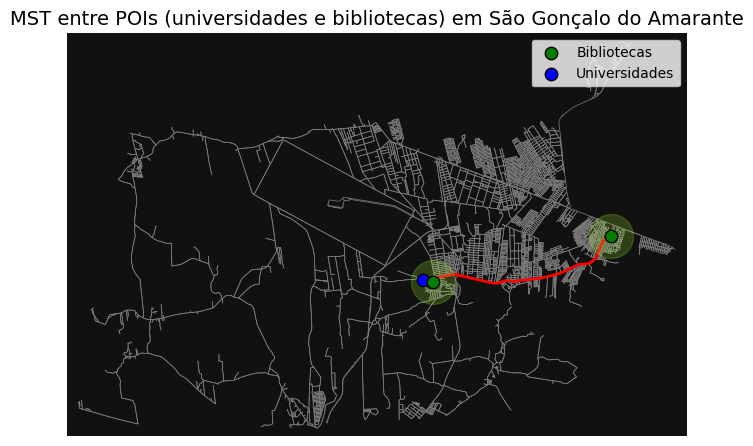

In [32]:
# Plotar o grafo base
fig, ax = ox.plot_graph(
    G_undirected, node_size=0, edge_color="gray", edge_linewidth=0.5, show=False, close=False
)

# Plotar também os POIs (bibliotecas) em verde
poi_x = [G_undirected.nodes[n]['x'] for n in library_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in library_nodes]
ax.scatter(poi_x, poi_y, c='greenyellow', s=1000, zorder=5, alpha=0.2)
ax.scatter(poi_x, poi_y, c='green', s=80, zorder=6, edgecolor='black', label='Bibliotecas')

# Destacar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotar também os POIs (universidades) em azul
poi_x = [G_undirected.nodes[n]['x'] for n in university_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in university_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black', label='Universidades')

plt.title("MST entre POIs (universidades e bibliotecas) em São Gonçalo do Amarante", fontsize=14)
ax.legend()
plt.savefig("gonçalo_mst.png", dpi=500, bbox_inches='tight')
plt.show()

## Extremoz

In [33]:
G = ox.graph_from_place(places[3], network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

Plotting the street network...


/tmp/ipython-input-4042706178.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


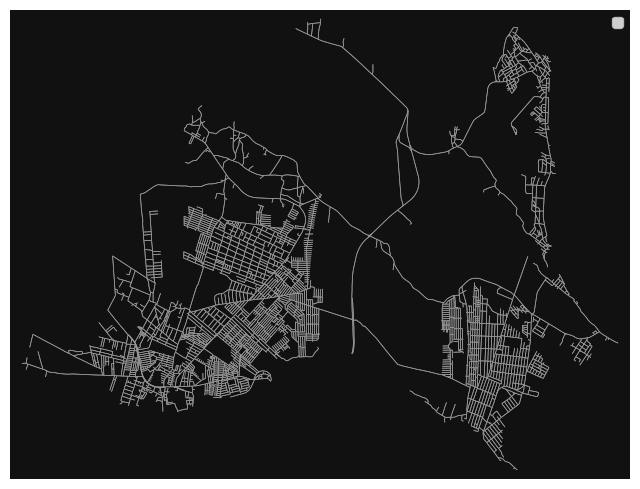

In [34]:
# Plot the street network
print("Plotting the street network...")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, show=False, close=False)

# Add a legend to distinguish source and destination
ax.legend(loc='upper right')

# Display the plot
plt.show()

In [35]:
# ============================================
# 2. Obter POIs de interesse
# ============================================
library_points = []
try:
  tags = {'amenity': 'library'}
  pois = ox.features.features_from_place(places[3], tags=tags)
  for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        library_points.append((row.geometry.y, row.geometry.x))
    else:
        library_points.append((row.geometry.centroid.y, row.geometry.centroid.x))
except:
  print("Nenhum biblioteca encontrada.")


# Extrair pontos representativos (centroides se for polígono)
university_points = []
try:
  tags = {'amenity': 'university'}
  pois = ox.features.features_from_place(places[3], tags=tags)
except:
  print("Nenhum universidade encontrada. Tentando escolas...")
  tags = {'amenity': 'school'}
  pois = ox.features.features_from_place(places[3], tags=tags)

for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        university_points.append((row.geometry.y, row.geometry.x))
    else:
        university_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not university_points:
    print("Nenhuma escola ou universidade encontrada.")

Nenhum biblioteca encontrada.
Nenhum universidade encontrada. Tentando escolas...


In [36]:
len(library_points)

0

In [37]:
len(university_points)

9

In [38]:
# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [hp[0] for hp in university_points]
longitudes = [hp[1] for hp in university_points]
university_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
university_nodes = list(set(university_nodes))

# latitudes = [hp[0] for hp in library_points]
# longitudes = [hp[1] for hp in library_points]
# library_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
# library_nodes = list(set(library_nodes))


In [39]:
# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for i in range(len(university_nodes)):
    for j in range(i+1, len(university_nodes)):
        route = nx.shortest_path(G_undirected, university_nodes[i], university_nodes[j], weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(university_nodes[i], university_nodes[j], weight=route_length)

In [40]:
# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_weight = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs):", total_mst_weight, "metros")

mean_mst_edge_weight = 0
std_dev_mst_edge_weight = 0
mst_edge_weights = [d['weight'] for (u, v, d) in mst_edges]
if mst_edge_weights:
    mean_mst_edge_weight = sum(mst_edge_weights) / len(mst_edge_weights)

    sum_sq_diff = sum([(w - mean_mst_edge_weight) ** 2 for w in mst_edge_weights])
    std_dev_mst_edge_weight = (sum_sq_diff / len(mst_edge_weights)) ** 0.5

    print(f"Média do peso das arestas do MST: {mean_mst_edge_weight:.2f} metros/aresta")
    print(f"Desvio padrão do peso das arestas do MST: {std_dev_mst_edge_weight:.2f} metros/aresta")

mst_routes = []
for (u, v, d) in mst_edges:
    route = nx.shortest_path(G_undirected, u, v, weight='length')
    mst_routes.append(route)

total_real_length = 0
edges_between_nodes = 0
for route in mst_routes:
    for i in range(len(route) - 1):
        edges_between_nodes = G_undirected.get_edge_data(route[i], route[i+1])
        for key in edges_between_nodes:
            total_real_length += edges_between_nodes[key]['length']


print("Comprimento total real da rede formada pelas rotas do MST:", total_real_length, "metros")

dados[places[3]] = [total_mst_weight, mean_mst_edge_weight, std_dev_mst_edge_weight, total_real_length]

Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs): 19382.452948525497 metros
Média do peso das arestas do MST: 2422.81 metros/aresta
Desvio padrão do peso das arestas do MST: 2993.65 metros/aresta
Comprimento total real da rede formada pelas rotas do MST: 38394.44535929126 metros


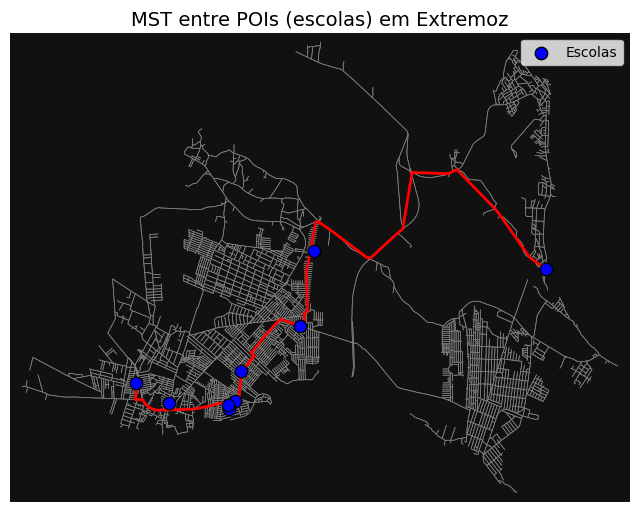

In [41]:
# Plotar o grafo base
fig, ax = ox.plot_graph(
    G_undirected, node_size=0, edge_color="gray", edge_linewidth=0.5, show=False, close=False
)

# # Plotar também os POIs (bibliotecas) em verde
# poi_x = [G_undirected.nodes[n]['x'] for n in library_nodes]
# poi_y = [G_undirected.nodes[n]['y'] for n in library_nodes]
# ax.scatter(poi_x, poi_y, c='greenyellow', s=1000, zorder=5, alpha=0.2)
# ax.scatter(poi_x, poi_y, c='green', s=80, zorder=6, edgecolor='black', label='Bibliotecas')

# Destacar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotar também os POIs (universidades) em azul
poi_x = [G_undirected.nodes[n]['x'] for n in university_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in university_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black', label='Escolas')

plt.title("MST entre POIs (escolas) em Extremoz", fontsize=14)
ax.legend()
plt.savefig("extremoz_mst.png", dpi=500, bbox_inches='tight')
plt.show()

## Macaíba

In [42]:
G = ox.graph_from_place(places[4], network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

Plotting the street network...


/tmp/ipython-input-4042706178.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


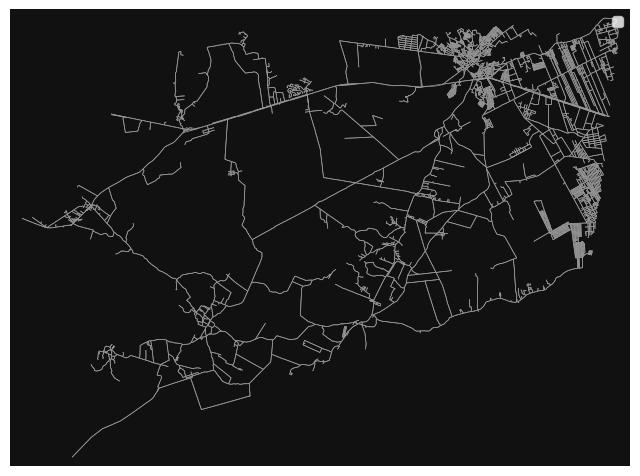

In [43]:
# Plot the street network
print("Plotting the street network...")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, show=False, close=False)

# Add a legend to distinguish source and destination
ax.legend(loc='upper right')

# Display the plot
plt.show()

In [44]:
# ============================================
# 2. Obter POIs de interesse
# ============================================
library_points = []
try:
  tags = {'amenity': 'library'}
  pois = ox.features.features_from_place(places[4], tags=tags)
  for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        library_points.append((row.geometry.y, row.geometry.x))
    else:
        library_points.append((row.geometry.centroid.y, row.geometry.centroid.x))
except:
  print("Nenhum biblioteca encontrada.")


# Extrair pontos representativos (centroides se for polígono)
university_points = []
try:
  tags = {'amenity': 'university'}
  pois = ox.features.features_from_place(places[4], tags=tags)
except:
  print("Nenhum universidade encontrada. Tentando escolas...")
  tags = {'amenity': 'school'}
  pois = ox.features.features_from_place(places[4], tags=tags)

for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        university_points.append((row.geometry.y, row.geometry.x))
    else:
        university_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not university_points:
    print("Nenhuma escola ou universidade encontrada.")

In [45]:
len(library_points)

1

In [46]:
len(university_points)

1

In [47]:
# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [hp[0] for hp in university_points]
longitudes = [hp[1] for hp in university_points]
university_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
university_nodes = list(set(university_nodes))

latitudes = [hp[0] for hp in library_points]
longitudes = [hp[1] for hp in library_points]
library_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
library_nodes = list(set(library_nodes))


In [48]:
# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for university in university_nodes:
    for library in library_nodes:
        route = nx.shortest_path(G_undirected, university, library, weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(university, library, weight=route_length)

In [49]:
# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_weight = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs):", total_mst_weight, "metros")

mean_mst_edge_weight = 0
std_dev_mst_edge_weight = 0
mst_edge_weights = [d['weight'] for (u, v, d) in mst_edges]
if mst_edge_weights:
    mean_mst_edge_weight = sum(mst_edge_weights) / len(mst_edge_weights)

    sum_sq_diff = sum([(w - mean_mst_edge_weight) ** 2 for w in mst_edge_weights])
    std_dev_mst_edge_weight = (sum_sq_diff / len(mst_edge_weights)) ** 0.5

    print(f"Média do peso das arestas do MST: {mean_mst_edge_weight:.2f} metros/aresta")
    print(f"Desvio padrão do peso das arestas do MST: {std_dev_mst_edge_weight:.2f} metros/aresta")

mst_routes = []
for (u, v, d) in mst_edges:
    route = nx.shortest_path(G_undirected, u, v, weight='length')
    mst_routes.append(route)

total_real_length = 0
edges_between_nodes = 0
for route in mst_routes:
    for i in range(len(route) - 1):
        edges_between_nodes = G_undirected.get_edge_data(route[i], route[i+1])
        for key in edges_between_nodes:
            total_real_length += edges_between_nodes[key]['length']


print("Comprimento total real da rede formada pelas rotas do MST:", total_real_length, "metros")

dados[places[4]] = [total_mst_weight, mean_mst_edge_weight, std_dev_mst_edge_weight, total_real_length]

Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs): 4875.603729639831 metros
Média do peso das arestas do MST: 4875.60 metros/aresta
Desvio padrão do peso das arestas do MST: 0.00 metros/aresta
Comprimento total real da rede formada pelas rotas do MST: 9496.631458855216 metros


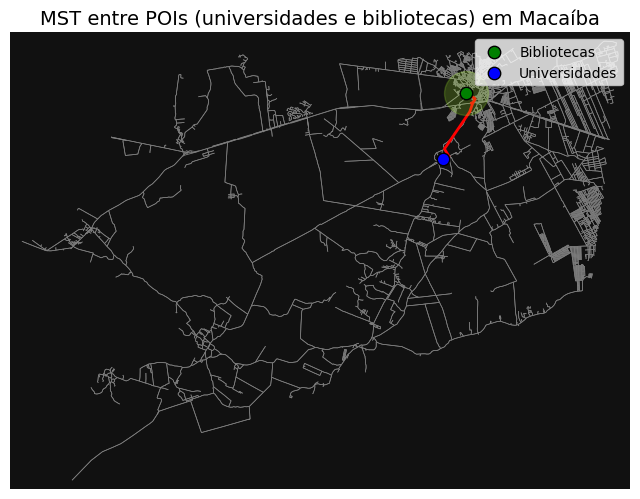

In [50]:
# Plotar o grafo base
fig, ax = ox.plot_graph(
    G_undirected, node_size=0, edge_color="gray", edge_linewidth=0.5, show=False, close=False
)

# Plotar também os POIs (bibliotecas) em verde
poi_x = [G_undirected.nodes[n]['x'] for n in library_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in library_nodes]
ax.scatter(poi_x, poi_y, c='greenyellow', s=1000, zorder=5, alpha=0.2)
ax.scatter(poi_x, poi_y, c='green', s=80, zorder=6, edgecolor='black', label='Bibliotecas')

# Destacar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotar também os POIs (universidades) em azul
poi_x = [G_undirected.nodes[n]['x'] for n in university_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in university_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black', label='Universidades')

plt.title("MST entre POIs (universidades e bibliotecas) em Macaíba", fontsize=14)
ax.legend()
plt.savefig("macaiba_mst.png", dpi=500, bbox_inches='tight')
plt.show()

## Ceará-Mirim

In [51]:
G = ox.graph_from_place(places[5], network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

Plotting the street network...


/tmp/ipython-input-4042706178.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


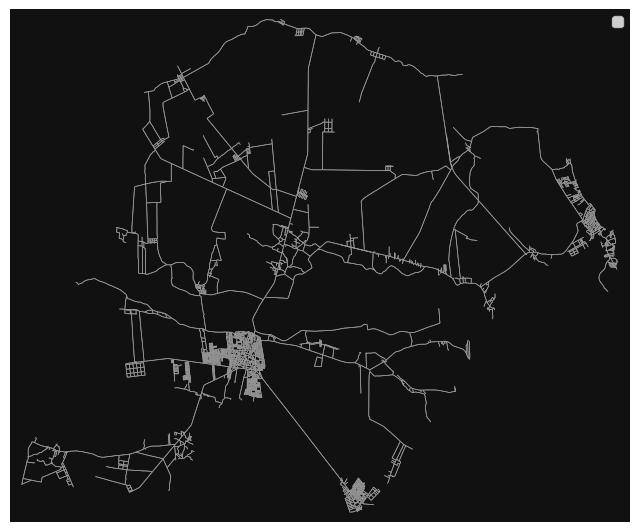

In [52]:
# Plot the street network
print("Plotting the street network...")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, show=False, close=False)

# Add a legend to distinguish source and destination
ax.legend(loc='upper right')

# Display the plot
plt.show()

In [53]:
# ============================================
# 2. Obter POIs de interesse
# ============================================
library_points = []
try:
  tags = {'amenity': 'library'}
  pois = ox.features.features_from_place(places[5], tags=tags)
  for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        library_points.append((row.geometry.y, row.geometry.x))
    else:
        library_points.append((row.geometry.centroid.y, row.geometry.centroid.x))
except:
  print("Nenhum biblioteca encontrada.")


# Extrair pontos representativos (centroides se for polígono)
university_points = []
try:
  tags = {'amenity': 'university'}
  pois = ox.features.features_from_place(places[5], tags=tags)
except:
  print("Nenhum universidade encontrada. Tentando escolas...")
  tags = {'amenity': 'school'}
  pois = ox.features.features_from_place(places[5], tags=tags)

for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        university_points.append((row.geometry.y, row.geometry.x))
    else:
        university_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not university_points:
    print("Nenhuma escola ou universidade encontrada.")

Nenhum universidade encontrada. Tentando escolas...


In [54]:
len(library_points)

1

In [55]:
len(university_points)

30

In [56]:
# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [hp[0] for hp in university_points]
longitudes = [hp[1] for hp in university_points]
university_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
university_nodes = list(set(university_nodes))

latitudes = [hp[0] for hp in library_points]
longitudes = [hp[1] for hp in library_points]
library_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
library_nodes = list(set(library_nodes))


In [57]:
# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for university in university_nodes:
    for library in library_nodes:
        route = nx.shortest_path(G_undirected, university, library, weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(university, library, weight=route_length)

In [58]:
# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_weight = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs):", total_mst_weight, "metros")

mean_mst_edge_weight = 0
std_dev_mst_edge_weight = 0
mst_edge_weights = [d['weight'] for (u, v, d) in mst_edges]
if mst_edge_weights:
    mean_mst_edge_weight = sum(mst_edge_weights) / len(mst_edge_weights)

    sum_sq_diff = sum([(w - mean_mst_edge_weight) ** 2 for w in mst_edge_weights])
    std_dev_mst_edge_weight = (sum_sq_diff / len(mst_edge_weights)) ** 0.5

    print(f"Média do peso das arestas do MST: {mean_mst_edge_weight:.2f} metros/aresta")
    print(f"Desvio padrão do peso das arestas do MST: {std_dev_mst_edge_weight:.2f} metros/aresta")

mst_routes = []
for (u, v, d) in mst_edges:
    route = nx.shortest_path(G_undirected, u, v, weight='length')
    mst_routes.append(route)

total_real_length = 0
edges_between_nodes = 0
for route in mst_routes:
    for i in range(len(route) - 1):
        edges_between_nodes = G_undirected.get_edge_data(route[i], route[i+1])
        for key in edges_between_nodes:
            total_real_length += edges_between_nodes[key]['length']


print("Comprimento total real da rede formada pelas rotas do MST:", total_real_length, "metros")

dados[places[5]] = [total_mst_weight, mean_mst_edge_weight, std_dev_mst_edge_weight, total_real_length]

Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs): 146297.30840527656 metros
Média do peso das arestas do MST: 5044.73 metros/aresta
Desvio padrão do peso das arestas do MST: 7803.71 metros/aresta
Comprimento total real da rede formada pelas rotas do MST: 283030.26249729225 metros


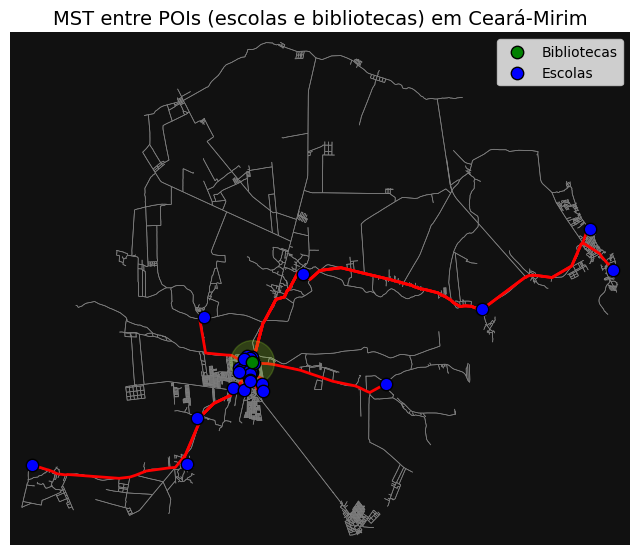

In [59]:
# Plotar o grafo base
fig, ax = ox.plot_graph(
    G_undirected, node_size=0, edge_color="gray", edge_linewidth=0.5, show=False, close=False
)

# Plotar também os POIs (bibliotecas) em verde
poi_x = [G_undirected.nodes[n]['x'] for n in library_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in library_nodes]
ax.scatter(poi_x, poi_y, c='greenyellow', s=1000, zorder=5, alpha=0.2)
ax.scatter(poi_x, poi_y, c='green', s=80, zorder=6, edgecolor='black', label='Bibliotecas')

# Destacar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotar também os POIs (universidades) em azul
poi_x = [G_undirected.nodes[n]['x'] for n in university_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in university_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black', label='Escolas')

plt.title("MST entre POIs (escolas e bibliotecas) em Ceará-Mirim", fontsize=14)
ax.legend()
plt.savefig("ceara_mst.png", dpi=500, bbox_inches='tight')
plt.show()

## São José de Mipibu

In [60]:
G = ox.graph_from_place(places[6], network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

Plotting the street network...


/tmp/ipython-input-4042706178.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


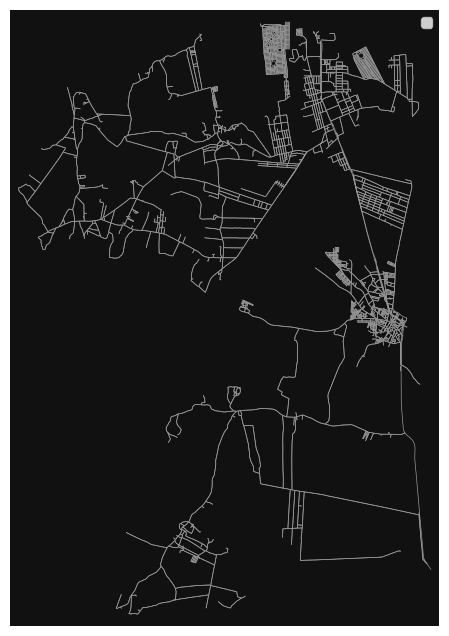

In [61]:
# Plot the street network
print("Plotting the street network...")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, show=False, close=False)

# Add a legend to distinguish source and destination
ax.legend(loc='upper right')

# Display the plot
plt.show()

In [62]:
# ============================================
# 2. Obter POIs de interesse
# ============================================
library_points = []
try:
  tags = {'amenity': 'library'}
  pois = ox.features.features_from_place(places[6], tags=tags)
  for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        library_points.append((row.geometry.y, row.geometry.x))
    else:
        library_points.append((row.geometry.centroid.y, row.geometry.centroid.x))
except:
  print("Nenhum biblioteca encontrada.")


# Extrair pontos representativos (centroides se for polígono)
university_points = []
try:
  tags = {'amenity': 'university'}
  pois = ox.features.features_from_place(places[6], tags=tags)
except:
  print("Nenhum universidade encontrada. Tentando escolas...")
  tags = {'amenity': 'school'}
  pois = ox.features.features_from_place(places[6], tags=tags)

for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        university_points.append((row.geometry.y, row.geometry.x))
    else:
        university_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not university_points:
    print("Nenhuma escola ou universidade encontrada.")

Nenhum biblioteca encontrada.
Nenhum universidade encontrada. Tentando escolas...


In [63]:
len(library_points)

0

In [64]:
len(university_points)

2

In [65]:
# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [hp[0] for hp in university_points]
longitudes = [hp[1] for hp in university_points]
university_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
university_nodes = list(set(university_nodes))

# latitudes = [hp[0] for hp in library_points]
# longitudes = [hp[1] for hp in library_points]
# library_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
# library_nodes = list(set(library_nodes))


In [66]:
# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for i in range(len(university_nodes)):
    for j in range(i+1, len(university_nodes)):
        route = nx.shortest_path(G_undirected, university_nodes[i], university_nodes[j], weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(university_nodes[i], university_nodes[j], weight=route_length)

In [67]:
# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_weight = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs):", total_mst_weight, "metros")

mean_mst_edge_weight = 0
std_dev_mst_edge_weight = 0
mst_edge_weights = [d['weight'] for (u, v, d) in mst_edges]
if mst_edge_weights:
    mean_mst_edge_weight = sum(mst_edge_weights) / len(mst_edge_weights)

    sum_sq_diff = sum([(w - mean_mst_edge_weight) ** 2 for w in mst_edge_weights])
    std_dev_mst_edge_weight = (sum_sq_diff / len(mst_edge_weights)) ** 0.5

    print(f"Média do peso das arestas do MST: {mean_mst_edge_weight:.2f} metros/aresta")
    print(f"Desvio padrão do peso das arestas do MST: {std_dev_mst_edge_weight:.2f} metros/aresta")


mst_routes = []
for (u, v, d) in mst_edges:
    route = nx.shortest_path(G_undirected, u, v, weight='length')
    mst_routes.append(route)

total_real_length = 0
edges_between_nodes = 0
for route in mst_routes:
    for i in range(len(route) - 1):
        edges_between_nodes = G_undirected.get_edge_data(route[i], route[i+1])
        for key in edges_between_nodes:
            total_real_length += edges_between_nodes[key]['length']


print("Comprimento total real da rede formada pelas rotas do MST:", total_real_length, "metros")

dados[places[6]] = [total_mst_weight, mean_mst_edge_weight, std_dev_mst_edge_weight, total_real_length]

Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs): 11332.998676198418 metros
Média do peso das arestas do MST: 11333.00 metros/aresta
Desvio padrão do peso das arestas do MST: 0.00 metros/aresta
Comprimento total real da rede formada pelas rotas do MST: 22665.99735239684 metros


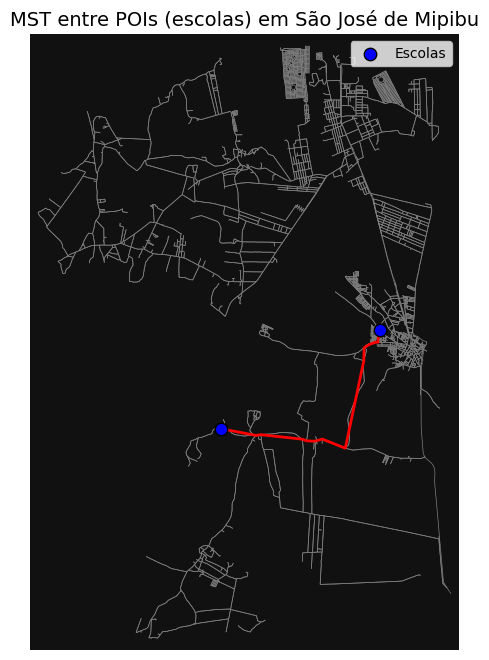

In [68]:
# Plotar o grafo base
fig, ax = ox.plot_graph(
    G_undirected, node_size=0, edge_color="gray", edge_linewidth=0.5, show=False, close=False
)

# # Plotar também os POIs (bibliotecas) em verde
# poi_x = [G_undirected.nodes[n]['x'] for n in library_nodes]
# poi_y = [G_undirected.nodes[n]['y'] for n in library_nodes]
# ax.scatter(poi_x, poi_y, c='greenyellow', s=1000, zorder=5, alpha=0.2)
# ax.scatter(poi_x, poi_y, c='green', s=80, zorder=6, edgecolor='black', label='Bibliotecas')

# Destacar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotar também os POIs (universidades) em azul
poi_x = [G_undirected.nodes[n]['x'] for n in university_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in university_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black', label='Escolas')

plt.title("MST entre POIs (escolas) em São José de Mipibu", fontsize=14)
ax.legend()
plt.savefig("saoJose_mst.png", dpi=500, bbox_inches='tight')
plt.show()

## Nísia Floresta

In [69]:
G = ox.graph_from_place(places[7], network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

Plotting the street network...


/tmp/ipython-input-4042706178.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


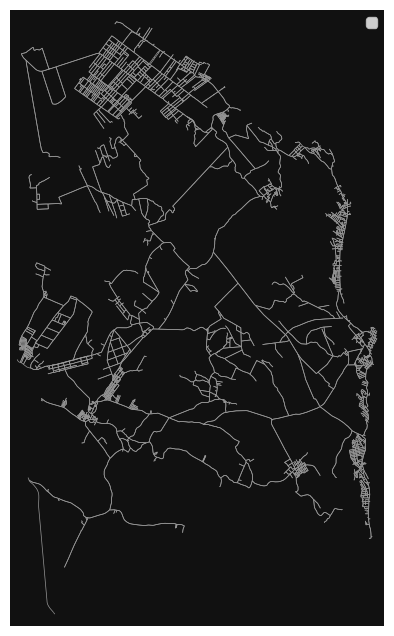

In [70]:
# Plot the street network
print("Plotting the street network...")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, show=False, close=False)

# Add a legend to distinguish source and destination
ax.legend(loc='upper right')

# Display the plot
plt.show()

In [71]:
# ============================================
# 2. Obter POIs de interesse
# ============================================
library_points = []
try:
  tags = {'amenity': 'library'}
  pois = ox.features.features_from_place(places[7], tags=tags)
  for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        library_points.append((row.geometry.y, row.geometry.x))
    else:
        library_points.append((row.geometry.centroid.y, row.geometry.centroid.x))
except:
  print("Nenhum biblioteca encontrada.")


# Extrair pontos representativos (centroides se for polígono)
university_points = []
try:
  tags = {'amenity': 'university'}
  pois = ox.features.features_from_place(places[7], tags=tags)
except:
  print("Nenhum universidade encontrada. Tentando escolas...")
  tags = {'amenity': 'school'}
  pois = ox.features.features_from_place(places[7], tags=tags)

for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        university_points.append((row.geometry.y, row.geometry.x))
    else:
        university_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not university_points:
    print("Nenhuma escola ou universidade encontrada.")

Nenhum biblioteca encontrada.
Nenhum universidade encontrada. Tentando escolas...


In [72]:
len(library_points)

0

In [73]:
len(university_points)

3

In [74]:
# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [hp[0] for hp in university_points]
longitudes = [hp[1] for hp in university_points]
university_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
university_nodes = list(set(university_nodes))

# latitudes = [hp[0] for hp in library_points]
# longitudes = [hp[1] for hp in library_points]
# library_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
# library_nodes = list(set(library_nodes))


In [75]:
# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for i in range(len(university_nodes)):
    for j in range(i+1, len(university_nodes)):
        route = nx.shortest_path(G_undirected, university_nodes[i], university_nodes[j], weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(university_nodes[i], university_nodes[j], weight=route_length)

In [76]:
# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_weight = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs):", total_mst_weight, "metros")

mean_mst_edge_weight = 0
std_dev_mst_edge_weight = 0
mst_edge_weights = [d['weight'] for (u, v, d) in mst_edges]
if mst_edge_weights:
    mean_mst_edge_weight = sum(mst_edge_weights) / len(mst_edge_weights)

    sum_sq_diff = sum([(w - mean_mst_edge_weight) ** 2 for w in mst_edge_weights])
    std_dev_mst_edge_weight = (sum_sq_diff / len(mst_edge_weights)) ** 0.5

    print(f"Média do peso das arestas do MST: {mean_mst_edge_weight:.2f} metros/aresta")
    print(f"Desvio padrão do peso das arestas do MST: {std_dev_mst_edge_weight:.2f} metros/aresta")


mst_routes = []
for (u, v, d) in mst_edges:
    route = nx.shortest_path(G_undirected, u, v, weight='length')
    mst_routes.append(route)

total_real_length = 0
edges_between_nodes = 0
for route in mst_routes:
    for i in range(len(route) - 1):
        edges_between_nodes = G_undirected.get_edge_data(route[i], route[i+1])
        for key in edges_between_nodes:
            total_real_length += edges_between_nodes[key]['length']


print("Comprimento total real da rede formada pelas rotas do MST:", total_real_length, "metros")

dados[places[7]] = [total_mst_weight, mean_mst_edge_weight, std_dev_mst_edge_weight, total_real_length]

Comprimento total do MST (soma dos pesos das arestas no grafo completo de POIs): 5708.665263414473 metros
Média do peso das arestas do MST: 2854.33 metros/aresta
Desvio padrão do peso das arestas do MST: 1862.94 metros/aresta
Comprimento total real da rede formada pelas rotas do MST: 11127.61161537144 metros


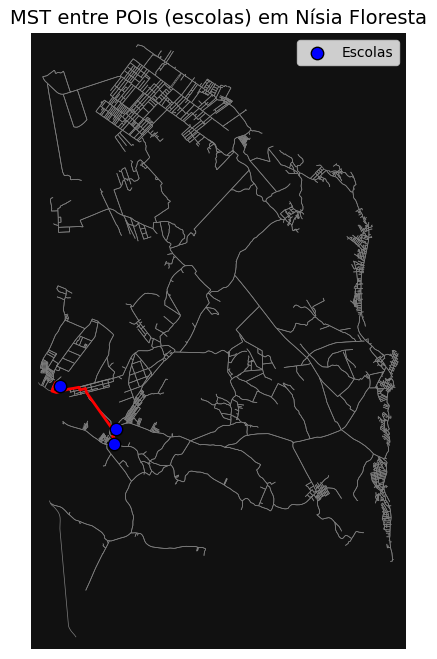

In [77]:
# Plotar o grafo base
fig, ax = ox.plot_graph(
    G_undirected, node_size=0, edge_color="gray", edge_linewidth=0.5, show=False, close=False
)

# # Plotar também os POIs (bibliotecas) em verde
# poi_x = [G_undirected.nodes[n]['x'] for n in library_nodes]
# poi_y = [G_undirected.nodes[n]['y'] for n in library_nodes]
# ax.scatter(poi_x, poi_y, c='greenyellow', s=1000, zorder=5, alpha=0.2)
# ax.scatter(poi_x, poi_y, c='green', s=80, zorder=6, edgecolor='black', label='Bibliotecas')

# Destacar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotar também os POIs (universidades) em azul
poi_x = [G_undirected.nodes[n]['x'] for n in university_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in university_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black', label='Escolas')

plt.title("MST entre POIs (escolas) em Nísia Floresta", fontsize=14)
ax.legend()
plt.savefig("nisia_mst.png", dpi=500, bbox_inches='tight')
plt.show()

### Métricas

Tabela de Métricas do MST por Cidade (em km):


,Comprimento total do MST,Média do peso,Desvio padrão do peso,Comprimento total real
"Natal, Rio Grande do Norte, Brazil",62.323721,2.492949,3.115227,74.915081
"Parnamirim, Rio Grande do Norte, Brazil",242.503962,5.639627,2.453703,327.175294
"São Gonçalo do Amarante, Rio Grande do Norte, Brazil",9.068808,4.534404,4.020346,17.156360
"Extremoz, Rio Grande do Norte, Brazil",19.382453,2.422807,2.993653,38.394445
"Macaíba, Rio Grande do Norte, Brazil",4.875604,4.875604,0.000000,9.496631
"Ceará-Mirim, Rio Grande do Norte, Brazil",146.297308,5.044735,7.803710,283.030262
"São José de Mipibu, Rio Grande do Norte, Brazil",11.332999,11.332999,0.000000,22.665997
"Nísia Floresta, Rio Grande do Norte, Brazil",5.708665,2.854333,1.862937,11.127612


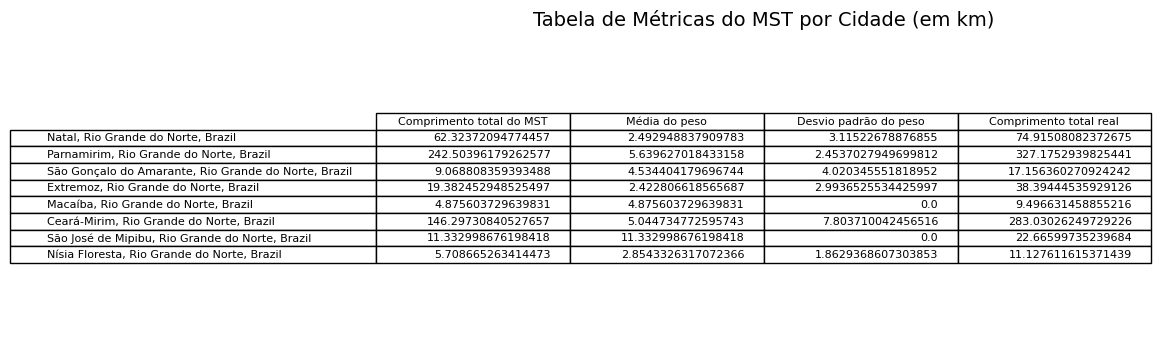

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

df_dados = pd.DataFrame.from_dict(dados, orient='index', columns=['Total MST Length (m)', 'Mean MST Edge Weight (m/edge)', 'Std Dev MST Edge Weight (m/edge)', 'total_real_length'])

# Convert meters to kilometers for better readability
df_dados['Comprimento total do MST'] = df_dados['Total MST Length (m)'] / 1000
df_dados['Média do peso'] = df_dados['Mean MST Edge Weight (m/edge)'] / 1000
df_dados['Desvio padrão do peso'] = df_dados['Std Dev MST Edge Weight (m/edge)'] / 1000
df_dados['Comprimento total real'] = df_dados['total_real_length'] / 1000

# Drop the original meter columns
df_dados = df_dados.drop(columns=['Total MST Length (m)', 'Mean MST Edge Weight (m/edge)', 'Std Dev MST Edge Weight (m/edge)'])

# Reorder columns for better presentation
df_dados = df_dados[['Comprimento total do MST', 'Média do peso', 'Desvio padrão do peso', 'Comprimento total real']]


# Display the table
print("Tabela de Métricas do MST por Cidade (em km):")
display(df_dados)

# Save the table as a PNG image
fig, ax = plt.subplots(figsize=(10, len(df_dados) * 0.5)) # Adjust figure size based on number of rows
ax.axis('off') # Hide the axes
ax.table(cellText=df_dados.values, colLabels=df_dados.columns, rowLabels=df_dados.index, loc='center')

plt.title("Tabela de Métricas do MST por Cidade (em km)", fontsize=14)
plt.savefig("mst_metrics_table.png", bbox_inches='tight', dpi=500)
plt.show()